<a href="https://colab.research.google.com/github/ianzin30/IF1014-Mining/blob/main/exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link dataset Nomao https://drive.google.com/drive/folders/1qnOMoNw4iNODx7e7e4-vWsPIaKi1VI4J?usp=sharing

Coloque os arquivos no mesmo nivel de sample_data

### Importando as bibliotecas que serão utilizadas ao decorrer dos códigos

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier



c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CRISP_DM PHASE 2


## Carregamento dos Dados

Aqui realizamos a leitura do conjunto de dados Nomao, esse armazenado nos arquivos `.data` e `.features`.  

- O arquivo **Nomao.features** contém os nomes das colunas.
- O arquivo **Nomao.data** contém os registros que analisaremos.

Após a leitura, convertemos esses arquivos em um DataFrame do Pandas para facilitar as operações futuras.


In [5]:
import os


file_path_features = os.path.join(os.getcwd(), "Nomao.features")
with open(file_path_features, 'r') as file:
    content_features = file.read()

file_path_data = os.path.join(os.getcwd(), "Nomao.data")
with open(file_path_data, 'r') as file:
    content_data = file.read()

features = content_features.split('\n')
data = list(map(lambda x: x.split(','), content_data.split('\n')))


## Primeira Visualização do Dataset

Antes de realizar qualquer transformação, é importante visualizar os primeiros registros para entender sua estrutura.

**Alvo da observação**  
- Os tipos de dados das colunas  
- A presença de valores ausentes (`?`)  
- A existência de colunas categóricas e numéricas  

Essa etapa inicial nos ajuda a definir as melhores estratégias de tratamento dos dados!


In [6]:
# Inicializando DataFrame do Nomao
nomao_df = pd.DataFrame(data, columns=features)
nomao_df.head(5)

,id,clean_name_intersect_min,clean_name_intersect_max,clean_name_levenshtein_sim,clean_name_trigram_sim,clean_name_levenshtein_term,clean_name_trigram_term,clean_name_including,clean_name_equality,city_intersect_min,...,coordinates_long_levenshtein,coordinates_long_trigram,coordinates_long_equality,coordinates_lat_diff,coordinates_lat_levenshtein,coordinates_lat_trigram,coordinates_lat_equality,geocode_coordinates_diff,coordinates_diff,label
0,0#1,1,1,1,1,1,1,s,s,?,...,0.75,0.5,n,0.999953002209,0.777777777778,0.461538463831,n,1.0,0.999999996702,+1
1,0#2,1,0.75,0.857143,0.857143,0.894737,0.947368,s,n,?,...,0.5,0.307692319155,n,0.999982921892,0.538461538462,0.4375,n,1.0,0.999999962459,+1
2,0#3,1,1,1,1,1,1,s,s,?,...,0.666666666667,0.461538463831,n,0.999992600055,0.8,0.666666686535,n,1.0,0.999999999653,+1
3,4#5,1,0.75,0.857143,0.857143,0.842105,0.833333,s,n,1,...,0.5,0.285714298487,n,0.998604948886,0.555555555556,0.384615391493,n,0.999999947284,0.999994124065,+1
4,6#7,0,0,0.25,0,0.25,0,n,n,?,...,?,?,m,?,?,?,m,1.0,?,+1


In [7]:
valor_faltante = nomao_df.isin(["?"]).any(axis=1).sum()

print(f"Número de linhas com pelo menos um valor faltante: {valor_faltante}")


Número de linhas com pelo menos um valor faltante: 34465


## 📊 Informações Gerais do Dataset

Agora vamos analisar a estrutura do DataFrame e obter estatísticas básicas.

📌 **Principais pontos analisados:**  
- Número total de linhas e colunas  
- Tipos de dados em cada coluna  

Essas informações são fundamentais para o próximo passo: o **pré-processamento**.


In [8]:
print(nomao_df.shape)

(34466, 120)


### Número de linhas e colunas
```python
# O dataset possui 34466 linhas e 120 colunas

In [9]:
nomao_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34466 entries, 0 to 34465
Columns: 120 entries, id to label
dtypes: object(120)
memory usage: 31.6+ MB


In [10]:
# Resumo estatístico das colunas numéricas (mesmo que estejam como 'object', aqui serve para uma noção inicial)
nomao_df.describe(include='all')


,id,clean_name_intersect_min,clean_name_intersect_max,clean_name_levenshtein_sim,clean_name_trigram_sim,clean_name_levenshtein_term,clean_name_trigram_term,clean_name_including,clean_name_equality,city_intersect_min,...,coordinates_long_levenshtein,coordinates_long_trigram,coordinates_long_equality,coordinates_lat_diff,coordinates_lat_levenshtein,coordinates_lat_trigram,coordinates_lat_equality,geocode_coordinates_diff,coordinates_diff,label
count,34466,34465,34465,34465,34465,34465,34465,34465,34465,34465,...,34465,34465,34465,34465,34465,34465,34465,34465,34465,34465
unique,33959,27,43,3942,2211,759,929,2,2,8,...,67,102,3,7164,56,104,3,8549,9382,2
top,12142#12143,1,0,1,1,1,1,s,n,?,...,?,?,m,?,?,?,m,1.0,?,+1
freq,2,17687,8935,8730,8730,8013,8759,17687,25735,22295,...,18965,18965,18965,18965,18965,18965,18965,15555,18965,24621


### Curiosidade interessante

Observando o retorno acima, percebemos que, por exemplo, o ID não é único, algo intrigante pela natureza do dataset. Precisamos posteriormente estudar se isso pode causar problemas ou não, ou seja, se precisaremos tratar ou não.

##  Analisando o Balanceamento das Classes

A variável **label** do dataset indica se dois pontos referem-se ao mesmo local ou não.

**Por que isso importa?**  
- Se houver desbalanceamento (muitas instâncias de uma classe e poucas de outra), os modelos podem ficar **tendenciosos**.  
- Técnicas como **reponderação de classes, oversampling e undersampling** podem ser necessárias para corrigir isso.

Aqui, plotamos um gráfico para visualizar a proporção das classes no dataset.

In [11]:
# Remover linhas onde a coluna 'label' tem valores ausentes ANTES de separar X e y
nomao_df = nomao_df.dropna(subset=['label'])

# Separar a coluna-alvo corretamente agora sem valores None
label_col = nomao_df['label']

# Remover a coluna 'label' do DataFrame de features
nomao_df = nomao_df.drop(columns=['label'])

# Verificar se ainda há valores nulos
print(label_col.isnull().sum())  # Deve imprimir 0
print(label_col.unique())  # Deve mostrar apenas ['+1', '-1']


0
['+1' '-1']


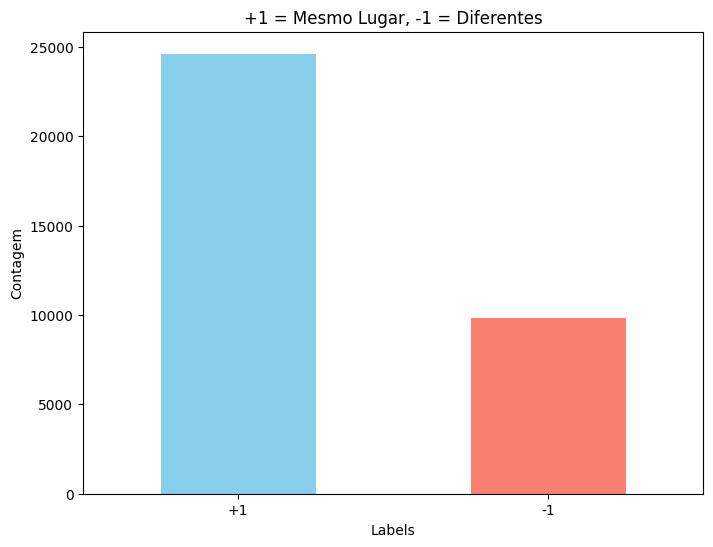

In [12]:
plt.figure(figsize=(8,6))
label_col.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('+1 = Mesmo Lugar, -1 = Diferentes')
plt.xlabel('Labels')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.show()


### Conclusão de balanceamento

É notório perceber que há uma clara quantidade maior de labels positivas do que negativas, resumindo, o modelo pode ser tendencioso para apontar que os locais são os mesmos pontos.

Essa falta de equilíbrio pode afetar a capacidade do modelo de identificar corretamente as instâncias negativas, o que pode resultar em um viés nas previsões. Para melhorar o desempenho e reduzir o viés, algumas abordagens podem ser consideradas:

1. Aplicar técnicas de balanceamento como undersampling ou oversampling.
2. Escolher nossos futuros algoritmos baseados nessa características do problema.
3. Ajustar a função de custo do modelo, atribuindo um peso maior para a classe minoritária.
4. Avaliar as métricas que utilizaremos, visto que o problema é desbalanceado e a acurácia pode não ser uma boa avaliação.


##  Separação de Variáveis Numéricas e Categóricas

Para facilitar as análises, dividimos as colunas do dataset em **numéricas** e **categóricas**.


In [13]:
# Exemplo de função que checa se a maioria dos valores são numéricos ou não
def transformar(series, threshold=0.9):
    filtragem_na = series.dropna()
    if len(filtragem_na) == 0:
        # Colunas inteiras de valores ausentes são consideradas não numéricas
        return False

    n_numeros = 0
    for val in filtragem_na:
        try:
            float(val)  # Tenta converter
            n_numeros += 1
        except ValueError:
            pass

    # Fracão de valores que foram convertidos com sucesso
    fraction = n_numeros / len(filtragem_na)

    return fraction >= threshold

# Da forma explicitada pelo autor, vamos substituir os valores '?' por NaN
nomao_df = nomao_df.replace('?', np.nan)


Colunas numéricas: 89
Colunas categóricas: 30


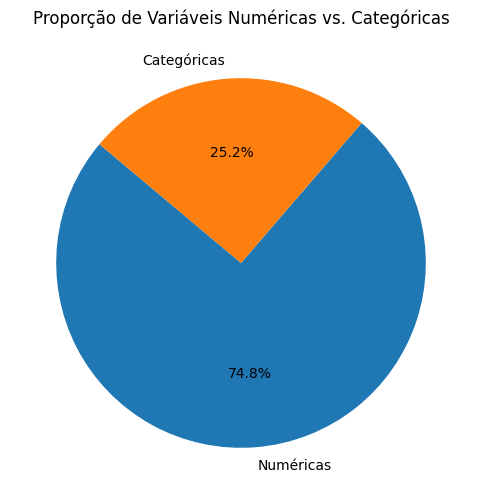

In [14]:
numericas = []
categoricas = []

for col in nomao_df.columns:
    # Se a coluna for convertível para numérico acima do threshold, convertemos
    if transformar(nomao_df[col], threshold=0.9):
        # Converter oficialmente para float (ou int) no DataFrame
        nomao_df[col] = pd.to_numeric(nomao_df[col], errors='coerce')
        numericas.append(col)
    else:
        nomao_df[col] = nomao_df[col].astype('category')
        categoricas.append(col)

print(f"Colunas numéricas: {len(numericas)}")
print(f"Colunas categóricas: {len(categoricas)}")

labels = ['Numéricas', 'Categóricas']
sizes = [len(numericas), len(categoricas)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proporção de Variáveis Numéricas vs. Categóricas')
plt.show()


### Intervalo de valores contínuos

Vamos ver como é distribuído o intervalo de valores contínuos do dataset

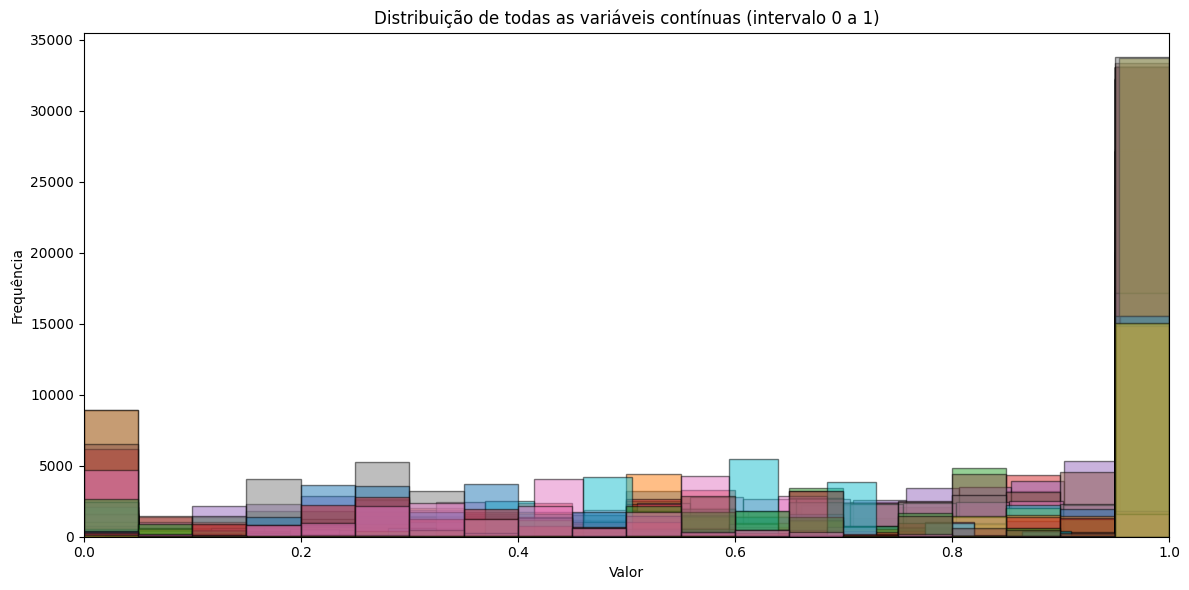

In [15]:


# Selecionando apenas as colunas numéricas contínuas
num_cols = nomao_df.select_dtypes(include=['float64', 'int64']).columns

# Plotando a distribuição das variáveis contínuas em um único histograma
plt.figure(figsize=(12, 6))

# Plotando todas as variáveis contínuas em um único gráfico
for col in num_cols:
    nomao_df[col].plot(kind='hist', bins=20, alpha=0.5, label=col, edgecolor='black')

# Configurações do gráfico
plt.title('Distribuição de todas as variáveis contínuas (intervalo 0 a 1)')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.xlim(0, 1)  # Intervalo de 0 a 1

plt.tight_layout()

# Exibindo o gráfico
plt.show()


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
def plot_group_info(values, title, xlabel, ylabel):
  def get_group_names(num_cols):
      """Cria um dicionário com nomes dos grupos e suas posições iniciais e finais."""
      grupos = defaultdict(list)

      # Criar grupos baseados no prefixo antes de "_"
      for i, nome in enumerate(num_cols):
          prefixo = nome.split("_")[0]
          grupos[prefixo].append(i)

      # Converter para um formato {nome: (pos_inicial, pos_final)}
      resultado = {k: (v[0], v[-1]) for k, v in grupos.items()}

      return resultado

  # Selecionando apenas as colunas numéricas contínuas e ordenando-as alfabeticamente
  num_cols = sorted(nomao_df.select_dtypes(include=['float64', 'int64']).columns)

  # Obter nomes dos grupos e posições no eixo X
  group_info = get_group_names(num_cols)

  # Definir cores distintas para cada grupo
  num_groups = len(group_info)
  colors = plt.cm.Paired(np.linspace(0, 1, num_groups))

  plt.figure(figsize=(12, 6))

  # Desenhando as barras com cores baseadas no grupo
  for i, (group_name, (start, end)) in enumerate(group_info.items()):
      plt.bar(range(start, end + 1), values[start:end + 1], color=colors[i], edgecolor='black')

  # Definir posições centrais dos grupos para rótulos do eixo X
  group_positions = [(start + end) / 2 for start, end in group_info.values()]

  # Aplicar nomes dos grupos no eixo X
  plt.xticks(group_positions, group_info.keys(), fontsize=10, rotation=45, ha='right')

  # Configurações do gráfico
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim(0, 1)  # Assumindo que as médias estejam entre 0 e 1
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  plt.tight_layout()
  plt.show()


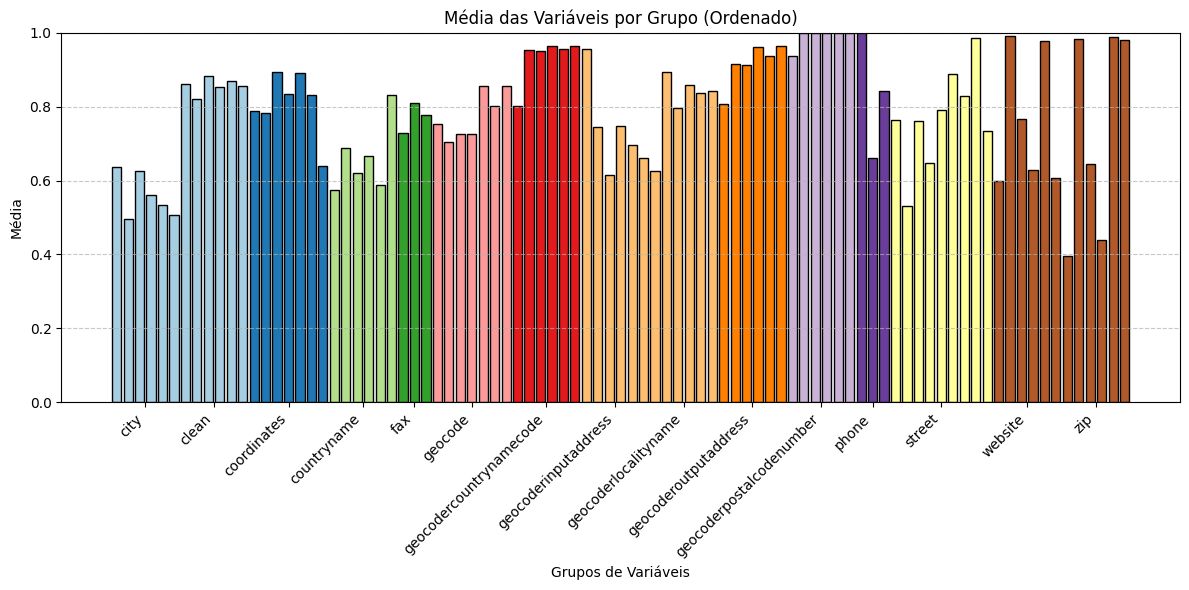

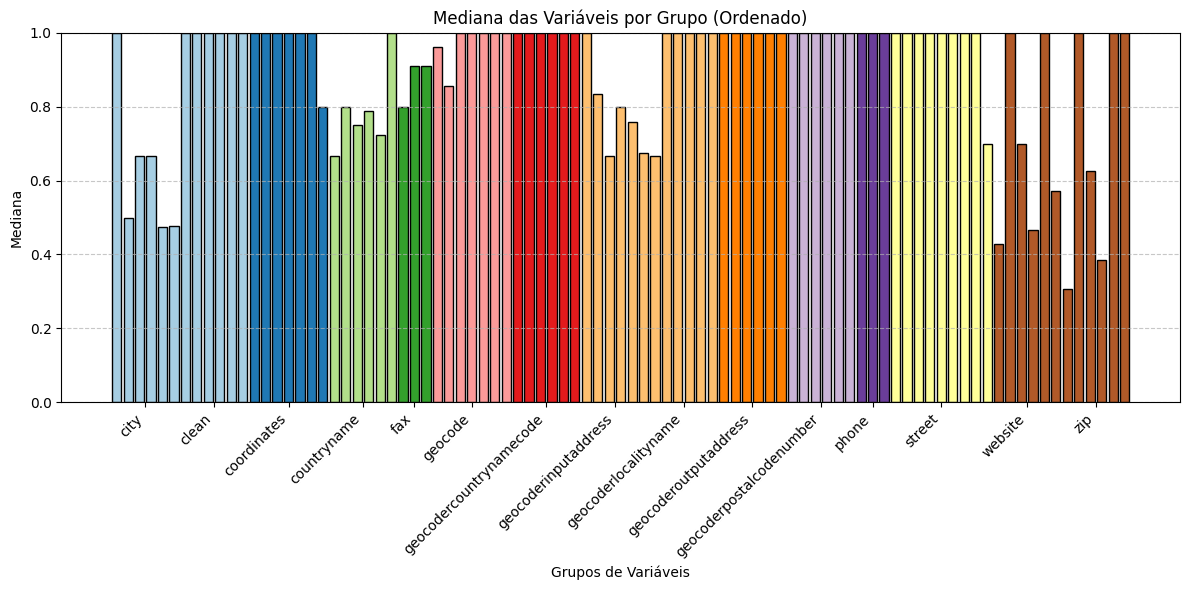

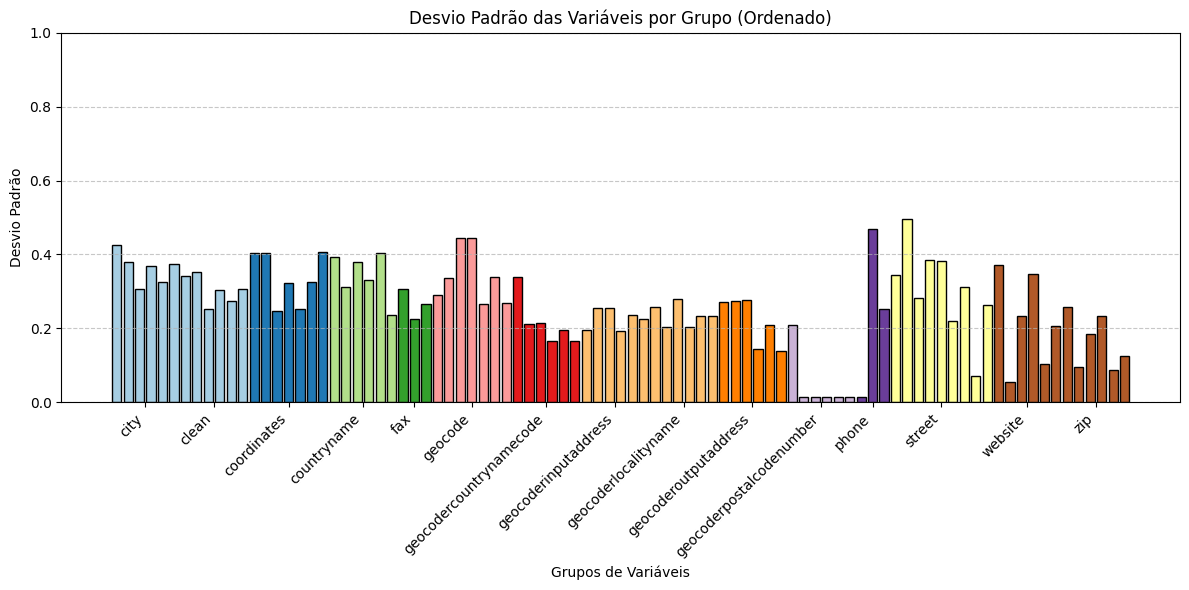

In [17]:
plot_group_info(values = nomao_df[num_cols].mean(), title = 'Média das Variáveis por Grupo (Ordenado)', xlabel = 'Grupos de Variáveis', ylabel = 'Média')
plot_group_info(values = nomao_df[num_cols].median(), title = 'Mediana das Variáveis por Grupo (Ordenado)', xlabel = 'Grupos de Variáveis', ylabel = 'Mediana')
plot_group_info(values = nomao_df[num_cols].std(), title = 'Desvio Padrão das Variáveis por Grupo (Ordenado)', xlabel = 'Grupos de Variáveis', ylabel = 'Desvio Padrão')


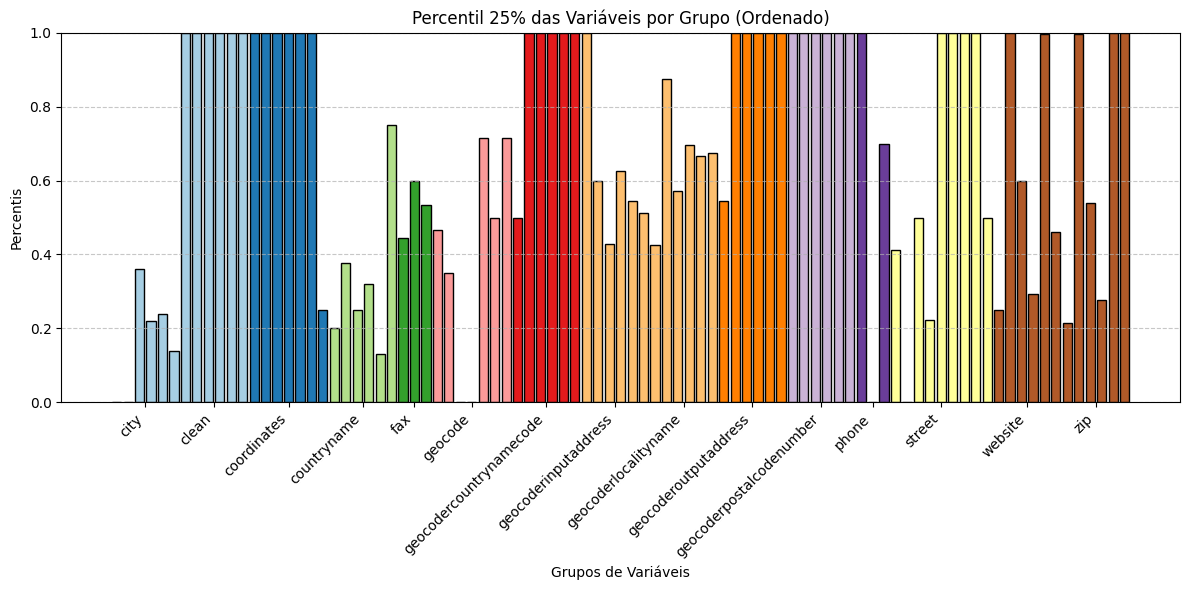

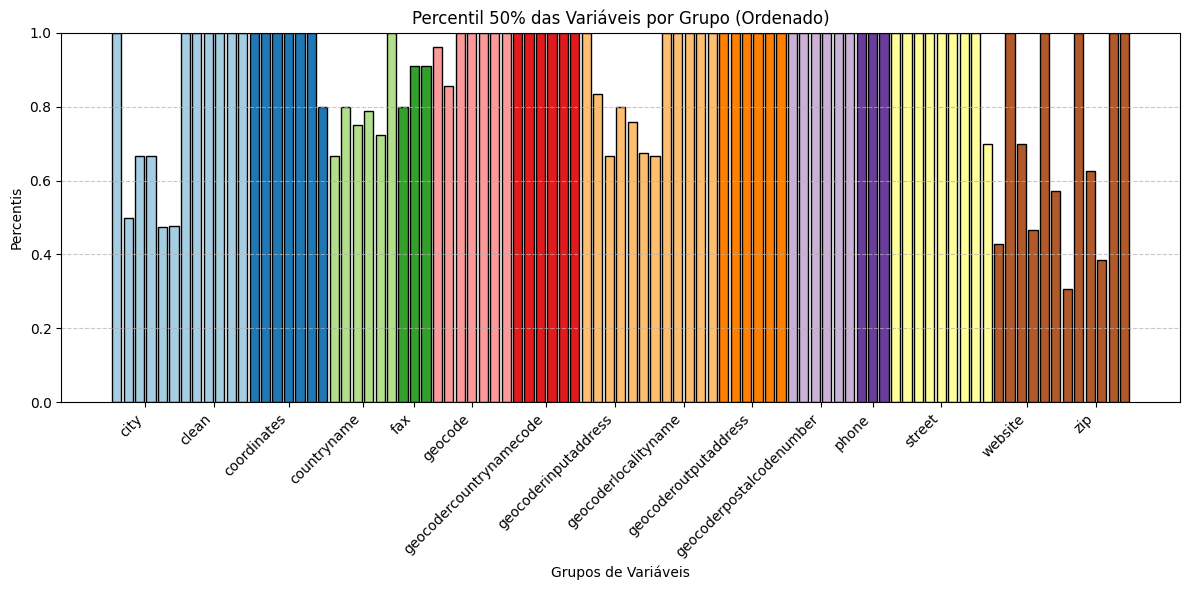

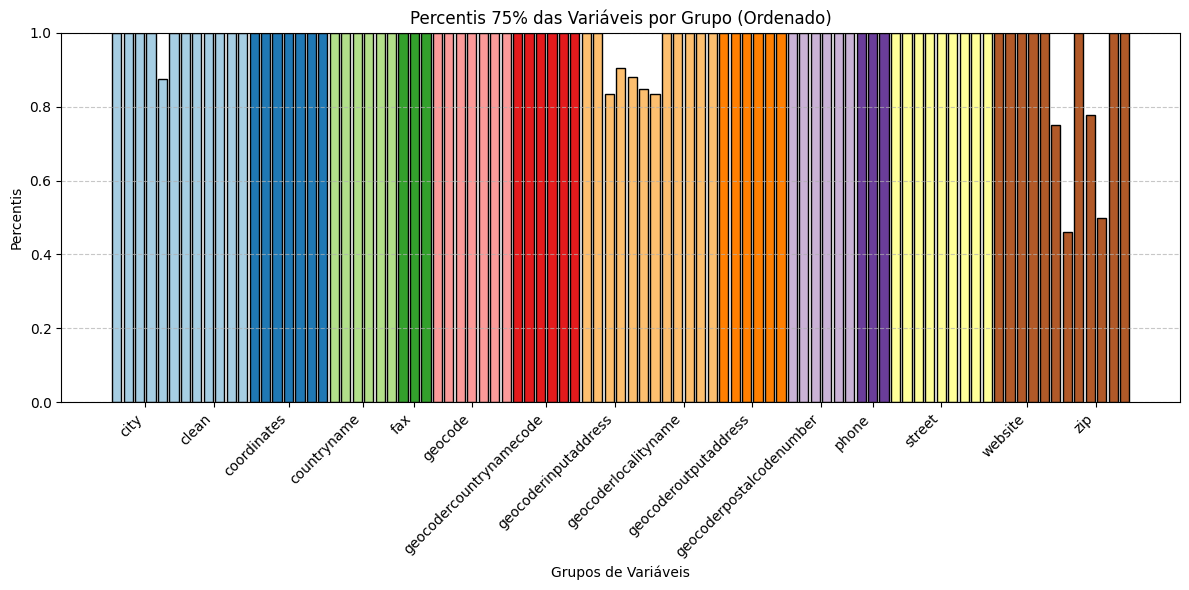

In [18]:
percentiles = nomao_df[num_cols].quantile([0.25, 0.5, 0.75])
percentiles = percentiles.T
plot_group_info(values=percentiles[0.25], title='Percentil 25% das Variáveis por Grupo (Ordenado)', xlabel='Grupos de Variáveis', ylabel='Percentis')
plot_group_info(values=percentiles[0.5], title='Percentil 50% das Variáveis por Grupo (Ordenado)', xlabel='Grupos de Variáveis', ylabel='Percentis')
plot_group_info(values=percentiles[0.75], title='Percentis 75% das Variáveis por Grupo (Ordenado)', xlabel='Grupos de Variáveis', ylabel='Percentis')

### Comentários

Aqui observamos que as colunas contínuas são distribuídas de forma que sempre ficam entre o intervalo de 0 a 1, ou seja, meio que normalizadas. O que levanta a dúvida se devemos ou não tratar os outliers que surgem de tal problema, visto que nesse caso não é de nossa expertise compreender se realmente os dados devem ser modificados, porém, segue abaixo o estudo de outliers

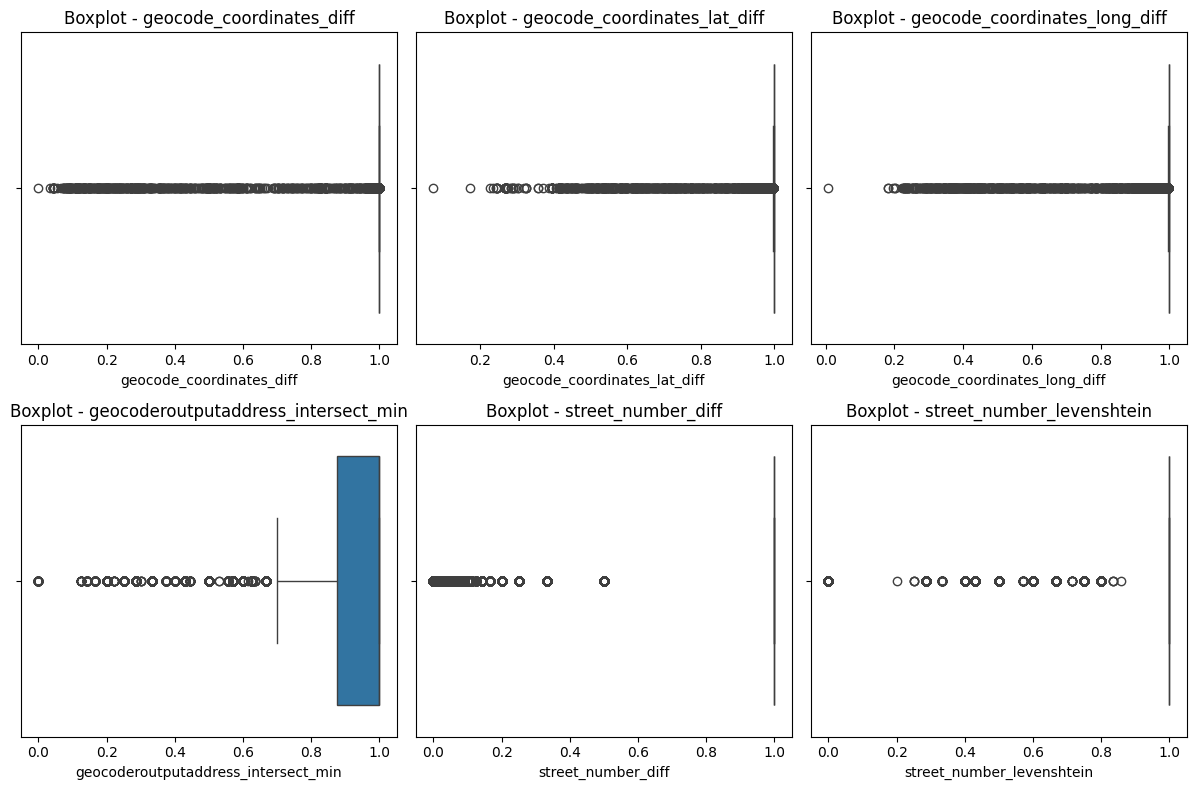

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculando o número de outliers para cada coluna
Q1 = nomao_df[num_cols].quantile(0.25)
Q3 = nomao_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((nomao_df[num_cols] < (Q1 - 1.5 * IQR)) | (nomao_df[num_cols] > (Q3 + 1.5 * IQR)))

# Contando o número de outliers por coluna
outliers_count = outliers.sum()

# Selecionando as 5 colunas com mais outliers
top_6_outliers = outliers_count.nlargest(6)

# Plotando os boxplots para as 5 colunas com mais outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(top_6_outliers.index):
    plt.subplot(2, 3, i+1)  # 2 linhas, 3 colunas de subplots
    sns.boxplot(x=nomao_df[col])
    plt.title(f'Boxplot - {col}')

plt.tight_layout()
plt.show()


In [20]:
outliers = {}

for col in num_cols:
    Q1 = nomao_df[col].quantile(0.25)
    Q3 = nomao_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Encontrando os outliers
    outliers[col] = nomao_df[(nomao_df[col] < lower_bound) | (nomao_df[col] > upper_bound)].shape[0]

# Exibindo os resultados
outliers_df = pd.DataFrame(list(outliers.items()), columns=["Feature", "Outliers Count"])
outliers_df = outliers_df.sort_values(by="Outliers Count", ascending=False)

from IPython.display import display, HTML
# Tornando a exibição rolável
display(HTML(outliers_df.to_html()))


,Feature,Outliers Count
87,geocode_coordinates_diff,7517
78,geocode_coordinates_lat_diff,6495
75,geocode_coordinates_long_diff,6477
48,geocoderoutputaddress_intersect_min,5906
72,street_number_diff,5297
73,street_number_levenshtein,5297
74,street_number_trigram,5297
88,coordinates_diff,3230
55,geocoderpostalcodenumber_intersect_max,2751
56,geocoderpostalcodenumber_levenshtein_sim,2751


Observamos então que existem outliers, mas esses outliers podem ser relacionados à natureza da localização do problema, logo, resolvemos a primeira vista não considerar como problema.

## Analisando Valores Ausentes

Um aspecto crítico na preparação dos dados é lidar com valores ausentes.  
No dataset NOMAO, os valores faltantes são representados pelo símbolo **`?`**.  

**Gráfico**  
- A porcentagem de valores ausentes em cada variável  

C:\Users\iantr\AppData\Local\Temp\ipykernel_268\1427798497.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=faltantes_porcentagem.index, y=faltantes_porcentagem.values, palette='viridis')


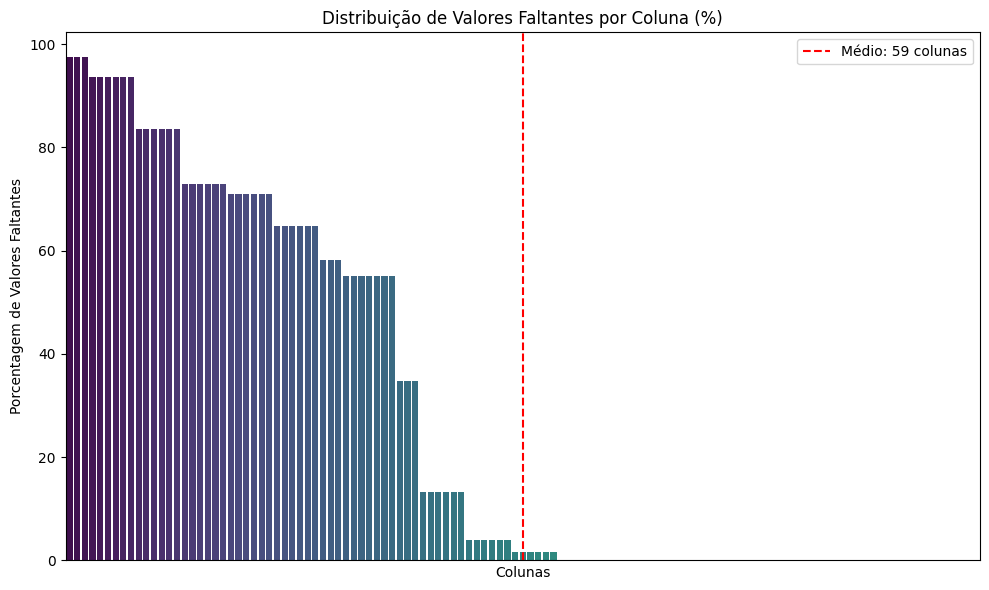

In [21]:


# Contar os valores faltantes por coluna
faltantes = nomao_df.isna().sum()

# Porcentagem de valores faltantes por coluna
faltantes_porcentagem = (faltantes / len(nomao_df)) * 100

# Ordenar as colunas por porcentagem de valores faltantes
faltantes_porcentagem = faltantes_porcentagem.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=faltantes_porcentagem.index, y=faltantes_porcentagem.values, palette='viridis')

# Escala
half_point = len(faltantes_porcentagem) // 2  # Meio do eixo x
plt.axvline(x=half_point, color='red', linestyle='--', label=f'Médio: {half_point} colunas')

# Configurações do gráfico
plt.title('Distribuição de Valores Faltantes por Coluna (%)')
plt.xlabel('Colunas')
plt.ylabel('Porcentagem de Valores Faltantes')
plt.xticks([])  # Para melhor visualização das colunas
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()


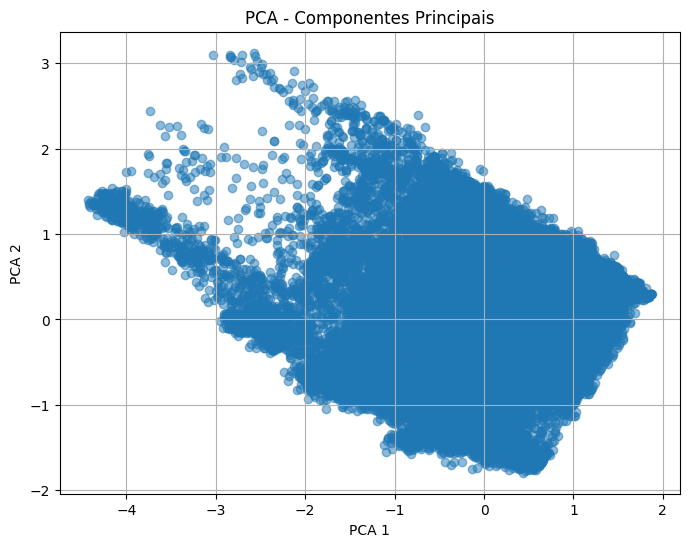

Variância explicada pelos componentes principais: [0.32373804 0.18042697]


In [22]:
# Selecionando apenas as colunas numéricas
num_cols = nomao_df.select_dtypes(include=['float64', 'int64']).columns

# Tratando valores ausentes (substituindo por média ou mediana)
nomao_df[num_cols] = nomao_df[num_cols].fillna(nomao_df[num_cols].mean())  # ou use mediana em vez de média

# Aplicando PCA
pca = PCA(n_components=2)  # Reduzindo para 2 componentes principais para visualização
pca_result = pca.fit_transform(nomao_df[num_cols])

# Criando um DataFrame com os componentes principais
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Plotando os resultados do PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], alpha=0.5)
plt.title('PCA - Componentes Principais')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# Verificando a variância explicada
explained_variance = pca.explained_variance_ratio_
print(f"Variância explicada pelos componentes principais: {explained_variance}")


c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


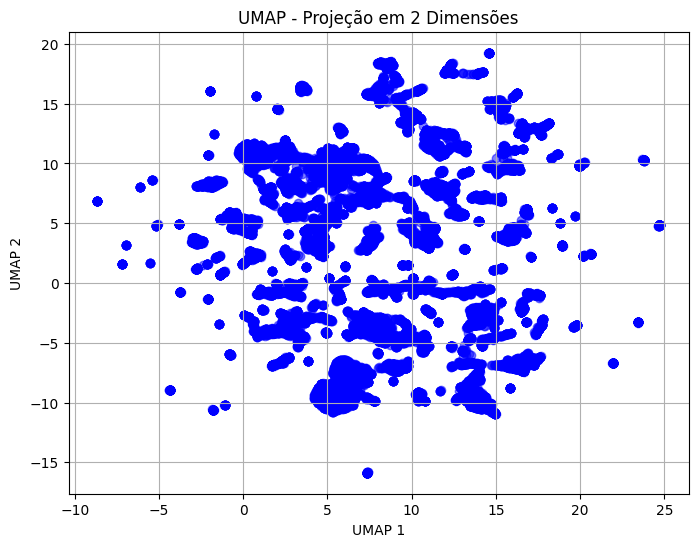

In [23]:
# Aplicando UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduzindo para 2 componentes
umap_result = umap_model.fit_transform(nomao_df[num_cols])

# Criando um DataFrame com os componentes UMAP
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])

# Plotando os resultados do UMAP
plt.figure(figsize=(8, 6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.5, c='blue')
plt.title('UMAP - Projeção em 2 Dimensões')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()


## Outliers

## Conclusões da Análise Exploratória

Após explorar o conjunto de dados, podemos concluir que:  

O dataset possui **120** variáveis e **34.466** registros.  
Existe um grande número de colunas ausentes.  
Detectamos que os valores contínuos são divididos em um intervalo de 0 a 1, o que pode configurar uma normalização.
O desbalanceamento sugere a necessidade de ajustes no treinamento dos modelos.


# CRISP_DM PHASE 3

## Transformar colunas categoricas
Transformar colunas categoricas em dummies, com valores numericos. (n, s, m) => (0,1,2)


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split


X = nomao_df
y = label_col              # Coluna-alvo

# Dividindo o dataset em treino (80%) e teste (20%), mantendo a consistência das classes
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    train_size=0.8,      
    random_state=42,      
    stratify=y            
)

print("Tamanho do treino:", X_train.shape[0])
print("Tamanho do teste :", X_test.shape[0])

X_train = X_train.drop(columns=['id'], errors='ignore')
X_test = X_test.drop(columns=['id'], errors='ignore')

train_df = pd.concat([X_train, y_train], axis=1)

test_df = pd.concat([X_test, y_test], axis=1)


Tamanho do treino: 27572
Tamanho do teste : 6893


In [25]:

# 2) Selecionar colunas numéricas e preencher valores faltantes com -1
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
train_df[numeric_cols] = train_df[numeric_cols].fillna(-1)


In [26]:
# Replicar para o conjunto de teste ( não é um problema nesse caso também, pois não é estatístico)
numeric_colunas = test_df.select_dtypes(include=[np.number]).columns
test_df[numeric_colunas] = test_df[numeric_colunas].fillna(-1)

In [27]:
missing_numeric = train_df[numeric_cols].isnull().sum()
print("Valores faltantes em colunas numéricas (treino):\n", missing_numeric)
print("Total faltante numérico (treino):", missing_numeric.sum())


Valores faltantes em colunas numéricas (treino):
 clean_name_intersect_min       0
clean_name_intersect_max       0
clean_name_levenshtein_sim     0
clean_name_trigram_sim         0
clean_name_levenshtein_term    0
                              ..
coordinates_lat_diff           0
coordinates_lat_levenshtein    0
coordinates_lat_trigram        0
geocode_coordinates_diff       0
coordinates_diff               0
Length: 89, dtype: int64
Total faltante numérico (treino): 0


In [28]:
missing_numeric = test_df[numeric_colunas].isnull().sum()
print("Valores faltantes em colunas numéricas (teste):\n", missing_numeric)
print("Total faltante numérico (teste):", missing_numeric.sum())

Valores faltantes em colunas numéricas (teste):
 clean_name_intersect_min       0
clean_name_intersect_max       0
clean_name_levenshtein_sim     0
clean_name_trigram_sim         0
clean_name_levenshtein_term    0
                              ..
coordinates_lat_diff           0
coordinates_lat_levenshtein    0
coordinates_lat_trigram        0
geocode_coordinates_diff       0
coordinates_diff               0
Length: 89, dtype: int64
Total faltante numérico (teste): 0


In [29]:
cat_cols = train_df.select_dtypes(include=['category']).columns
print("Colunas categóricas identificadas:", list(cat_cols))


Colunas categóricas identificadas: ['clean_name_including', 'clean_name_equality', 'city_including', 'city_equality', 'zip_including', 'zip_equality', 'street_including', 'street_equality', 'website_including', 'website_equality', 'countryname_including', 'countryname_equality', 'geocoderlocalityname_including', 'geocoderlocalityname_equality', 'geocoderinputaddress_including', 'geocoderinputaddress_equality', 'geocoderoutputaddress_including', 'geocoderoutputaddress_equality', 'geocoderpostalcodenumber_including', 'geocoderpostalcodenumber_equality', 'geocodercountrynamecode_including', 'geocodercountrynamecode_equality', 'phone_equality', 'fax_equality', 'street_number_equality', 'geocode_coordinates_long_equality', 'geocode_coordinates_lat_equality', 'coordinates_long_equality', 'coordinates_lat_equality']


In [30]:

# Selecionar colunas categóricas corretamente 
cat_cols = train_df.select_dtypes(include=['category']).columns

# Garantir que há colunas categóricas antes de aplicar One-Hot Encoding
if len(cat_cols) > 0:
    # Aplicar One-Hot Encoding
    train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)
    train_df = train_df.astype('float64')  # Garantir que os tipos são float
    print("One-Hot Encoding aplicado com sucesso!")
    print("Novas colunas criadas:", list(train_df.columns))
else:
    print("Nenhuma coluna categórica encontrada para One-Hot Encoding.")

# Conferir se ainda há valores nulos após a transformação
missing_data_cat = train_df.isnull().sum()
total_missing_cat = missing_data_cat.sum()
print("Valores faltantes após One-Hot Encoding:\n", missing_data_cat[missing_data_cat > 0])
print("Total faltante categórico (treino):", total_missing_cat)


One-Hot Encoding aplicado com sucesso!
Novas colunas criadas: ['clean_name_intersect_min', 'clean_name_intersect_max', 'clean_name_levenshtein_sim', 'clean_name_trigram_sim', 'clean_name_levenshtein_term', 'clean_name_trigram_term', 'city_intersect_min', 'city_intersect_max', 'city_levenshtein_sim', 'city_trigram_sim', 'city_levenshtein_term', 'city_trigram_term', 'zip_intersect_min', 'zip_intersect_max', 'zip_levenshtein_sim', 'zip_trigram_sim', 'zip_levenshtein_term', 'zip_trigram_term', 'street_intersect_min', 'street_intersect_max', 'street_levenshtein_sim', 'street_trigram_sim', 'street_levenshtein_term', 'street_trigram_term', 'website_intersect_min', 'website_intersect_max', 'website_levenshtein_sim', 'website_trigram_sim', 'website_levenshtein_term', 'website_trigram_term', 'countryname_intersect_min', 'countryname_intersect_max', 'countryname_levenshtein_sim', 'countryname_trigram_sim', 'countryname_levenshtein_term', 'countryname_trigram_term', 'geocoderlocalityname_intersect

In [31]:

# Selecionar colunas categóricas corretamente (as que não são numéricas de fato)
cat_cols_test = test_df.select_dtypes(include=['category']).columns

# Garantir que há colunas categóricas antes de aplicar One-Hot Encoding
if len(cat_cols_test) > 0:
    # Aplicar One-Hot Encoding
    # 4) Aplicar get_dummies no test_df
    test_df = pd.get_dummies(test_df, columns=cat_cols_test, drop_first=True)
    test_df = test_df.astype('float64')  # Garantir que os tipos são float
    print("One-Hot Encoding aplicado com sucesso!")
    test_df = test_df.reindex(columns=train_df.columns, fill_value=0)  # Garantir que as colunas são as mesmas
else:
    print("Nenhuma coluna categórica encontrada para One-Hot Encoding.")

# Conferir se ainda há valores nulos após a transformação
missing_data_cat = test_df.isnull().sum()
total_missing_cat = missing_data_cat.sum()
print("Valores faltantes após One-Hot Encoding:\n", missing_data_cat[missing_data_cat > 0])
print("Total faltante categórico (teste):", total_missing_cat)

One-Hot Encoding aplicado com sucesso!
Valores faltantes após One-Hot Encoding:
 Series([], dtype: int64)
Total faltante categórico (teste): 0


In [32]:
train_df.to_pickle("train.pkl")
test_df.to_pickle("test.pkl")

print("Arquivos 'train.pkl' e 'test.pkl' salvos com sucesso!")

Arquivos 'train.pkl' e 'test.pkl' salvos com sucesso!


```python

# Rodem a partir daqui

In [68]:
train_df = pd.read_pickle("train.pkl")
test_df = pd.read_pickle("test.pkl")

In [69]:
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

## Desbalanceamento

Utilizando SMOTE para suprir a diferença de classes

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# Definindo o pipeline com SMOTE + KNN
pipeline_knn = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# Definindo os hiperparâmetros para o KNN utilizando range
# Note que os hiperparâmetros agora estão prefixados com "knn__"
param_dist_knn = {
    'knn__n_neighbors': list(range(1, 31)),  # Testa de 1 a 30 vizinhos
    'knn__weights': ['uniform', 'distance'],
    'knn__p': list(range(1, 3))  # p=1 para Manhattan e p=2 para Euclidiana
}

# Usando a mesma estratégia de validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurando o RandomizedSearchCV para o Pipeline (SMOTE + KNN)
knn_search = RandomizedSearchCV(
    estimator=pipeline_knn,
    param_distributions=param_dist_knn,
    n_iter=20,                   # 20 iterações conforme solicitado
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Ajustando o modelo com os dados de treino (X_train, y_train)
knn_search.fit(X_train, y_train)

print("Melhores hiperparâmetros KNN:", knn_search.best_params_)
print("Melhor pontuação KNN:", knn_search.best_score_)

# Recupera o melhor estimador treinado para KNN
best_knn = knn_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros KNN: {'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 1}
Melhor pontuação KNN: 0.943648331064488


In [37]:
X_test

,clean_name_intersect_min,clean_name_intersect_max,clean_name_levenshtein_sim,clean_name_trigram_sim,clean_name_levenshtein_term,clean_name_trigram_term,city_intersect_min,city_intersect_max,city_levenshtein_sim,city_trigram_sim,...,street_number_equality_n,street_number_equality_s,geocode_coordinates_long_equality_n,geocode_coordinates_long_equality_s,geocode_coordinates_lat_equality_n,geocode_coordinates_lat_equality_s,coordinates_long_equality_n,coordinates_long_equality_s,coordinates_lat_equality_n,coordinates_lat_equality_s
8344,1.0,0.333333,0.500000,0.500000,0.200000,0.225000,0.860946,0.82159,0.883386,0.854119,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
34415,0.5,0.250000,0.370370,0.333333,0.387097,0.297297,1.000000,1.00000,1.000000,1.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
25176,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.860946,0.82159,0.883386,0.854119,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
33922,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.860946,0.82159,0.883386,0.854119,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12167,0.0,0.000000,0.183333,0.000000,0.190476,0.000000,0.860946,0.82159,0.883386,0.854119,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33994,0.0,0.000000,0.261905,0.041667,0.217391,0.032258,1.000000,1.00000,1.000000,1.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1656,1.0,0.833333,0.909091,0.909091,0.765957,0.770833,0.860946,0.82159,0.883386,0.854119,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12466,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
26004,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.860946,0.82159,0.883386,0.854119,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [38]:
# Célula: Avaliação do melhor modelo KNN no conjunto de teste
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Realizando predições no conjunto de teste com o melhor KNN
y_pred_knn = best_knn.predict(X_test)

# Calculando as métricas de avaliação
print("Acurácia KNN:", accuracy_score(y_test, y_pred_knn))
print("Precisão KNN:", precision_score(y_test, y_pred_knn, average='macro'))
print("Recall KNN:", recall_score(y_test, y_pred_knn, average='macro'))
print("F1-Score KNN:", f1_score(y_test, y_pred_knn, average='macro'))
print("Matriz de Confusão KNN:\n", confusion_matrix(y_test, y_pred_knn))


Acurácia KNN: 0.9551719135354708
Precisão KNN: 0.9444321085884286
Recall KNN: 0.9459165810930512
F1-Score KNN: 0.9451701632533311
Matriz de Confusão KNN:
 [[1820  149]
 [ 160 4764]]


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes=None, normalize=False, cmap=plt.cm.Blues):
    """
    Plota a matriz de confusão para um modelo de classificação.
    
    Parâmetros:
    -----------
    y_true: array-like
        Rótulos verdadeiros.
    y_pred: array-like
        Rótulos previstos pelo modelo.
    classes: list, default=None
        Lista com os nomes das classes para rotular os eixos. 
        Se None, os rótulos numéricos são usados.
    normalize: bool, default=False
        Se True, normaliza a matriz de confusão por linha (exibe proporções em vez de contagens).
    cmap: colormap, default=plt.cm.Blues
        Mapa de cores para o heatmap.
    """
    
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Normaliza a matriz, se desejado
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Cria uma figura
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,              # Exibe valores dentro das células
        fmt='.2f' if normalize else 'd',  # Formato de exibição
        cmap=cmap,
        xticklabels=classes if classes else range(cm.shape[1]),
        yticklabels=classes if classes else range(cm.shape[0])
    )
    
    plt.title('Matriz de Confusão' + (' (Normalizada)' if normalize else ''))
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Prevista')
    plt.show()


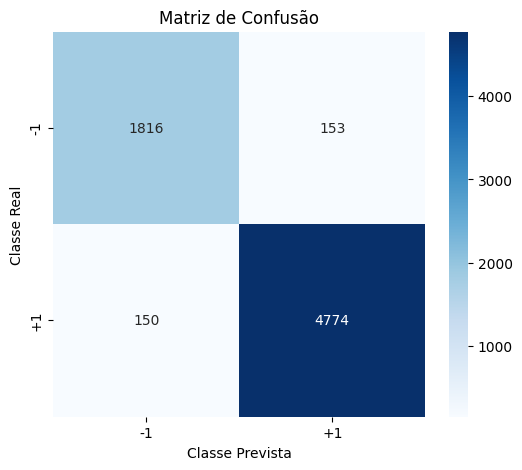

In [92]:
class_names = ['-1', '+1']  # Ajuste conforme suas classes

y_pred_knn = best_knn.predict(X_test)
plot_confusion_matrix(y_test, y_pred_knn, classes=class_names, normalize=False)


In [39]:
from sklearn.metrics import accuracy_score

# Predição no conjunto de treino
y_train_pred = best_knn.predict(X_train)
acuracia_treino = accuracy_score(y_train, y_train_pred)
print("Acurácia no Treinamento:", acuracia_treino)

# Predição no conjunto de teste
y_test_pred = best_knn.predict(X_test)
acuracia_teste = accuracy_score(y_test, y_test_pred)
print("Acurácia no Teste:", acuracia_teste)


Acurácia no Treinamento: 0.9999637313216306
Acurácia no Teste: 0.9551719135354708


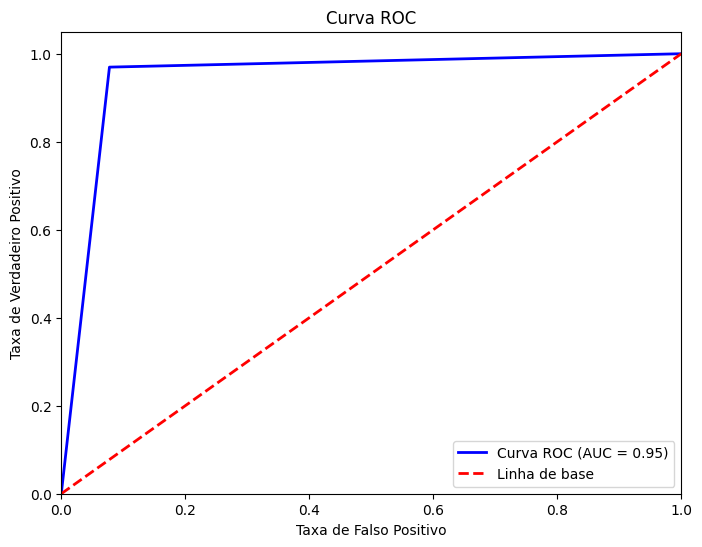

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Supondo que X_test, y_test e best_model já estejam definidos.
# Para modelos que não possuem método predict_proba, use decision_function se disponível.
y_proba = best_knn.predict_proba(X_test)[:, 1]  # Probabilidades para a classe positiva

# Cálculo dos pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Linha de base')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


In [40]:

cv_results_knn_df = pd.DataFrame(knn_search.cv_results_)
cv_results_knn_df.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_p,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.099759,0.009444,18.345493,0.267043,uniform,1,12,"{'weights': 'uniform', 'p': 1, 'n_neighbors': 12}",0.943044,0.942203,0.947607,0.938368,0.938732,0.941991,0.003360,10
1,0.095600,0.008110,2.428630,0.088394,distance,2,12,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.946997,0.942721,0.947441,0.939351,0.938813,0.943065,0.003650,6
2,0.102611,0.019748,18.823843,0.301255,uniform,1,2,"{'weights': 'uniform', 'p': 1, 'n_neighbors': 2}",0.939918,0.938784,0.938248,0.935869,0.931794,0.936923,0.002885,18
3,0.111125,0.021881,2.391926,0.035569,distance,2,14,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.946806,0.940170,0.949144,0.938276,0.936877,0.942255,0.004843,9
4,0.102631,0.006973,2.778650,0.185097,uniform,2,7,"{'weights': 'uniform', 'p': 2, 'n_neighbors': 7}",0.943315,0.938888,0.940405,0.939470,0.937506,0.939917,0.001942,15


In [41]:
cv_results_knn_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,params,mean_test_score,std_test_score,rank_test_score
0,"{'weights': 'uniform', 'p': 1, 'n_neighbors': 12}",0.941991,0.003360,10
1,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.943065,0.003650,6
2,"{'weights': 'uniform', 'p': 1, 'n_neighbors': 2}",0.936923,0.002885,18
3,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.942255,0.004843,9
4,"{'weights': 'uniform', 'p': 2, 'n_neighbors': 7}",0.939917,0.001942,15
5,"{'weights': 'uniform', 'p': 1, 'n_neighbors': 17}",0.940877,0.003748,13
6,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.948085,0.003565,1
7,"{'weights': 'uniform', 'p': 2, 'n_neighbors': 3}",0.941619,0.002217,12
8,"{'weights': 'uniform', 'p': 1, 'n_neighbors': 11}",0.943624,0.003491,4
9,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.939085,0.003928,16


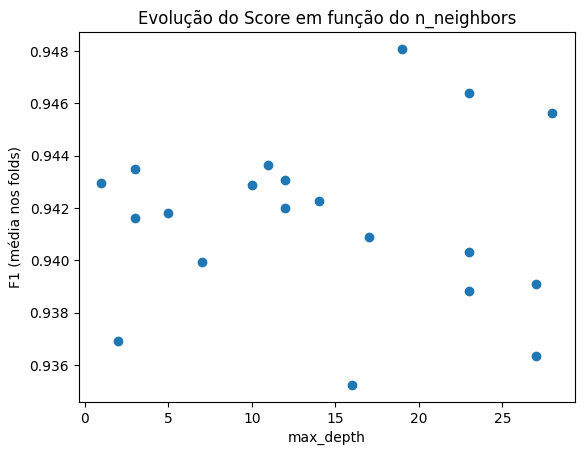

In [93]:
import matplotlib.pyplot as plt

plt.scatter(
    cv_results_knn_df['param_n_neighbors'], 
    cv_results_knn_df['mean_test_score']
)
plt.xlabel('max_depth')
plt.ylabel('F1 (média nos folds)')
plt.title('Evolução do Score em função do n_neighbors')
plt.show()

In [54]:

from sklearn.ensemble import RandomForestClassifier

# Definindo o pipeline com SMOTE + RandomForest
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Definindo os hiperparâmetros para o RandomForest utilizando range e prefixando com "rf__"
param_dist_rf = {
    'rf__n_estimators': range(50, 301, 50),            # Valores: 50, 100, 150, 200, 250, 300
    'rf__max_depth': [None] + list(range(5, 26, 5)),      # None, 5, 10, 15, 20, 25
    'rf__min_samples_split': range(2, 11),              # 2 até 10
    'rf__min_samples_leaf': range(1, 5),                # 1 até 4
    'rf__bootstrap': [True, False]                      # Uso de bootstrap: True ou False
}

# Definindo a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurando o RandomizedSearchCV para o pipeline (SMOTE + RandomForest)
rf_search = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=50,                  # Número de combinações aleatórias a avaliar
    scoring='f1_macro',         # Métrica de avaliação (pode ser alterada conforme necessário)
    cv=cv,
    random_state=42,
    n_jobs=-1,                  # Utiliza todos os núcleos disponíveis
    verbose=1
)

# Ajusta o pipeline com os dados de treino
rf_search.fit(X_train, y_train)

# Exibe os melhores hiperparâmetros e a melhor pontuação média de cross-validation
print("Melhores hiperparâmetros (Random Forest):", rf_search.best_params_)
print("Melhor pontuação (F1 Macro):", rf_search.best_score_)

# Recupera o melhor modelo encontrado
best_rf = rf_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores hiperparâmetros (Random Forest): {'rf__n_estimators': 300, 'rf__min_samples_split': 6, 'rf__min_samples_leaf': 1, 'rf__max_depth': None, 'rf__bootstrap': False}
Melhor pontuação (F1 Macro): 0.9618354592501761


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predição no conjunto de treino
y_train_pred = best_rf.predict(X_train)

print("Acurácia (Treino):", accuracy_score(y_train, y_train_pred))
print("Precisão (Treino):", precision_score(y_train, y_train_pred, average='macro'))
print("Recall (Treino):", recall_score(y_train, y_train_pred, average='macro'))
print("F1 (Treino):", f1_score(y_train, y_train_pred, average='macro'))


Acurácia (Treino): 0.9967720876251269
Precisão (Treino): 0.9957647443528272
Recall (Treino): 0.9963307956815598
F1 (Treino): 0.9960472475363977


In [46]:
from sklearn.metrics import confusion_matrix

# Predição no conjunto de teste
y_test_pred = best_rf.predict(X_test)

print("Acurácia (Teste):", accuracy_score(y_test, y_test_pred))
print("Precisão (Teste):", precision_score(y_test, y_test_pred, average='macro'))
print("Recall (Teste):", recall_score(y_test, y_test_pred, average='macro'))
print("F1 (Teste):", f1_score(y_test, y_test_pred, average='macro'))
print("Matriz de Confusão (Teste):\n", confusion_matrix(y_test, y_test_pred))


Acurácia (Teste): 0.9689540113158277
Precisão (Teste): 0.9623537471622583
Recall (Teste): 0.961506519203627
F1 (Teste): 0.9619288509491888
Matriz de Confusão (Teste):
 [[1859  110]
 [ 104 4820]]


In [94]:
cv_results_rf_df = pd.DataFrame(rf_search.cv_results_)
cv_results_rf_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_depth,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,32.905297,0.762969,0.344578,0.136695,200,9,3,20,False,"{'rf__n_estimators': 200, 'rf__min_samples_spl...",0.960675,0.959441,0.963441,0.957137,0.957414,0.959622,0.002314,10
1,15.445356,0.755087,0.102862,0.015948,100,8,3,15,False,"{'rf__n_estimators': 100, 'rf__min_samples_spl...",0.958377,0.957779,0.961455,0.955419,0.955943,0.957795,0.002136,22
2,32.999726,2.038160,0.353548,0.084729,300,2,3,15,True,"{'rf__n_estimators': 300, 'rf__min_samples_spl...",0.956027,0.955389,0.958629,0.953706,0.954705,0.955691,0.001658,33
3,11.682895,0.917672,0.098489,0.014900,100,5,4,15,True,"{'rf__n_estimators': 100, 'rf__min_samples_spl...",0.955995,0.955356,0.959301,0.952647,0.953209,0.955301,0.002362,35
4,45.368395,0.946492,0.312425,0.056660,300,4,1,15,False,"{'rf__n_estimators': 300, 'rf__min_samples_spl...",0.960079,0.957305,0.962598,0.957137,0.955436,0.958511,0.002528,18


In [95]:
cv_results_rf_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,params,mean_test_score,std_test_score,rank_test_score
0,"{'rf__n_estimators': 200, 'rf__min_samples_spl...",0.959622,0.002314,10
1,"{'rf__n_estimators': 100, 'rf__min_samples_spl...",0.957795,0.002136,22
2,"{'rf__n_estimators': 300, 'rf__min_samples_spl...",0.955691,0.001658,33
3,"{'rf__n_estimators': 100, 'rf__min_samples_spl...",0.955301,0.002362,35
4,"{'rf__n_estimators': 300, 'rf__min_samples_spl...",0.958511,0.002528,18
5,"{'rf__n_estimators': 150, 'rf__min_samples_spl...",0.957090,0.003007,28
6,"{'rf__n_estimators': 250, 'rf__min_samples_spl...",0.960708,0.002877,3
7,"{'rf__n_estimators': 200, 'rf__min_samples_spl...",0.956484,0.002181,31
8,"{'rf__n_estimators': 250, 'rf__min_samples_spl...",0.926970,0.002775,45
9,"{'rf__n_estimators': 300, 'rf__min_samples_spl...",0.957211,0.002506,27


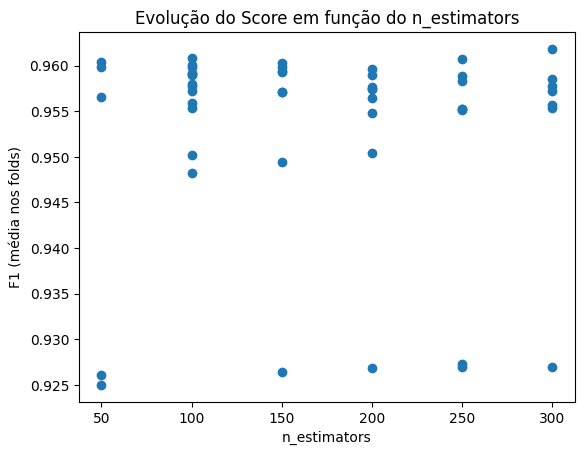

In [98]:
import matplotlib.pyplot as plt

plt.scatter(
    cv_results_rf_df['param_rf__n_estimators'], 
    cv_results_rf_df['mean_test_score']
)
plt.xlabel('n_estimators')
plt.ylabel('F1 (média nos folds)')
plt.title('Evolução do Score em função do n_estimators')
plt.show()

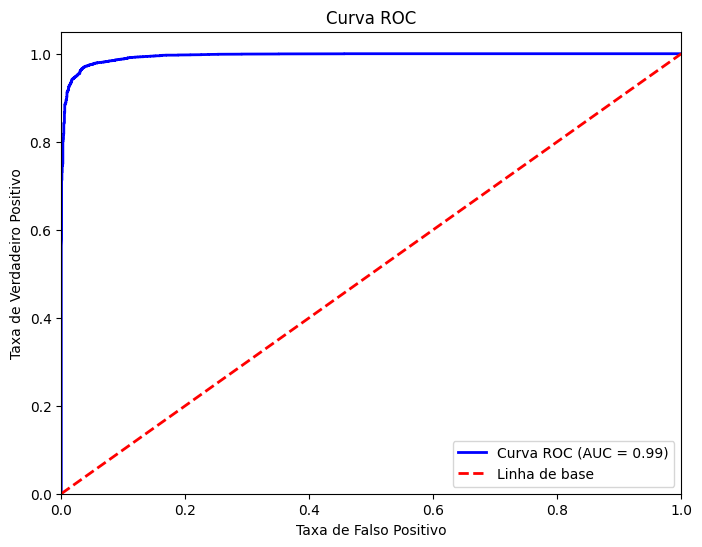

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Supondo que X_test, y_test e best_model já estejam definidos.
# Para modelos que não possuem método predict_proba, use decision_function se disponível.
y_proba = best_rf.predict_proba(X_test)[:, 1]  # Probabilidades para a classe positiva

# Cálculo dos pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Linha de base')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


In [47]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Faz predições no conjunto de treino e teste, 
    imprime métricas de classificação e retorna as predições.
    """
    # Predição no conjunto de treino
    y_train_pred = model.predict(X_train)
    print("==== MÉTRICAS NO TREINO ====")
    print("Acurácia (Treino):", accuracy_score(y_train, y_train_pred))
    print("Precisão (Treino):", precision_score(y_train, y_train_pred, average='macro'))
    print("Recall (Treino):", recall_score(y_train, y_train_pred, average='macro'))
    print("F1 (Treino):", f1_score(y_train, y_train_pred, average='macro'))
    print()

    # Predição no conjunto de teste
    y_test_pred = model.predict(X_test)
    print("==== MÉTRICAS NO TESTE ====")
    print("Acurácia (Teste):", accuracy_score(y_test, y_test_pred))
    print("Precisão (Teste):", precision_score(y_test, y_test_pred, average='macro'))
    print("Recall (Teste):", recall_score(y_test, y_test_pred, average='macro'))
    print("F1 (Teste):", f1_score(y_test, y_test_pred, average='macro'))
    print("Matriz de Confusão (Teste):\n", confusion_matrix(y_test, y_test_pred))

    return y_train_pred, y_test_pred


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 1) Definindo o espaço de hiperparâmetros para a Decision Tree
param_dist_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],  
    'max_depth': range(1, 100),                     
    'min_samples_split': range(2, 11),             
    'min_samples_leaf': range(1, 11)               
}

# 2) Instancia o modelo base
dt = DecisionTreeClassifier(random_state=42)

# 3) Configura a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) RandomizedSearchCV para a Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist_dt,
    n_iter=20,                # Número de combinações aleatórias
    scoring='f1_macro',       # Métrica (pode ajustar para 'accuracy', etc.)
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 5) Ajusta o modelo com os dados de treino
random_search_dt.fit(X_train, y_train)

# 6) Imprime os melhores hiperparâmetros e a melhor pontuação de cross-validation
print("Melhores hiperparâmetros Decision Tree:", random_search_dt.best_params_)
print("Melhor pontuação (F1 Macro):", random_search_dt.best_score_)

# 7) Recupera o melhor estimador
best_dt = random_search_dt.best_estimator_



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros Decision Tree: {'min_samples_split': 7, 'min_samples_leaf': 6, 'max_depth': 10, 'criterion': 'gini'}
Melhor pontuação (F1 Macro): 0.9398018478543932


In [49]:
# 9) Avalia o melhor modelo de Decision Tree
evaluate_model(best_dt, X_train, y_train, X_test, y_test)

==== MÉTRICAS NO TREINO ====
Acurácia (Treino): 0.9681198317133324
Precisão (Treino): 0.9621014713786018
Recall (Treino): 0.9595859010033758
F1 (Treino): 0.9608324255470395

==== MÉTRICAS NO TESTE ====
Acurácia (Teste): 0.9505295227041927
Precisão (Teste): 0.9408735563654627
Recall (Teste): 0.937485843737971
F1 (Teste): 0.9391579732679136
Matriz de Confusão (Teste):
 [[1786  183]
 [ 158 4766]]


(array([-1., -1., -1., ...,  1.,  1., -1.]),
 array([ 1., -1.,  1., ...,  1.,  1.,  1.]))

In [50]:
# Exemplo com random_search_dt (RandomizedSearchCV para Decision Tree)
cv_results_df = pd.DataFrame(random_search_dt.cv_results_)
cv_results_df.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.523554,0.025904,0.015512,0.001506,7,6,10,gini,"{'min_samples_split': 7, 'min_samples_leaf': 6...",0.944708,0.934134,0.944641,0.935436,0.940091,0.939802,0.004444,1
1,0.585316,0.010081,0.017161,0.000725,10,9,20,log_loss,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.943121,0.939076,0.935118,0.926466,0.933350,0.935426,0.005608,14
2,0.614357,0.004220,0.014518,0.000723,8,1,19,log_loss,"{'min_samples_split': 8, 'min_samples_leaf': 1...",0.944983,0.938490,0.935625,0.931327,0.931458,0.936376,0.005075,8
3,0.557291,0.014840,0.013273,0.001615,9,7,18,log_loss,"{'min_samples_split': 9, 'min_samples_leaf': 7...",0.941677,0.936294,0.935524,0.928244,0.939864,0.936321,0.004629,9
4,0.136133,0.009216,0.013429,0.001693,3,10,2,log_loss,"{'min_samples_split': 3, 'min_samples_leaf': 1...",0.880628,0.873310,0.880275,0.866356,0.875014,0.875117,0.005235,19


In [51]:
cv_results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]


,params,mean_test_score,std_test_score,rank_test_score
0,"{'min_samples_split': 7, 'min_samples_leaf': 6...",0.939802,0.004444,1
1,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.935426,0.005608,14
2,"{'min_samples_split': 8, 'min_samples_leaf': 1...",0.936376,0.005075,8
3,"{'min_samples_split': 9, 'min_samples_leaf': 7...",0.936321,0.004629,9
4,"{'min_samples_split': 3, 'min_samples_leaf': 1...",0.875117,0.005235,19
5,"{'min_samples_split': 7, 'min_samples_leaf': 4...",0.935997,0.004634,13
6,"{'min_samples_split': 9, 'min_samples_leaf': 2...",0.926487,0.002862,18
7,"{'min_samples_split': 8, 'min_samples_leaf': 3...",0.933291,0.003472,16
8,"{'min_samples_split': 9, 'min_samples_leaf': 2...",0.937252,0.002961,5
9,"{'min_samples_split': 8, 'min_samples_leaf': 3...",0.934889,0.004075,15


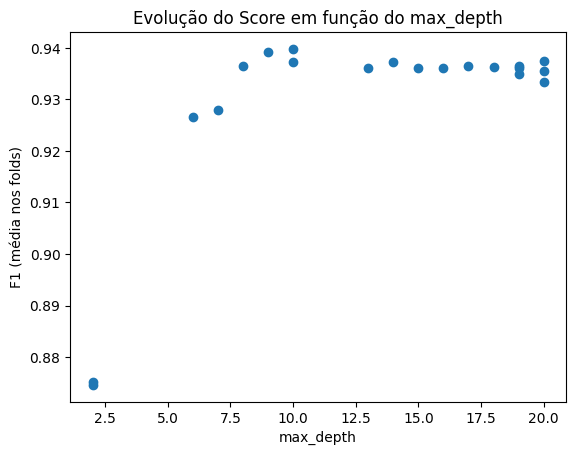

In [52]:
import matplotlib.pyplot as plt

plt.scatter(
    cv_results_df['param_max_depth'], 
    cv_results_df['mean_test_score']
)
plt.xlabel('max_depth')
plt.ylabel('F1 (média nos folds)')
plt.title('Evolução do Score em função do max_depth')
plt.show()


In [55]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# Definindo o pipeline com SMOTE + MLP
pipeline_mlp = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('mlp', MLPClassifier(random_state=42, max_iter=1000))
])

# Definindo os hiperparâmetros para o MLP, com prefixo 'mlp__'
param_dist_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50), (100,100)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [1e-4, 1e-3, 1e-2],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1]
}

# Definindo a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurando o RandomizedSearchCV para o pipeline (SMOTE + MLP)
mlp_search = RandomizedSearchCV(
    estimator=pipeline_mlp,
    param_distributions=param_dist_mlp,
    n_iter=20,               # Número de combinações aleatórias a avaliar
    scoring='f1_macro',      # Métrica de avaliação
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Ajusta o pipeline com os dados de treino (X_train, y_train)
mlp_search.fit(X_train, y_train)

print("Melhores hiperparâmetros (MLP):", mlp_search.best_params_)
print("Melhor pontuação (F1 Macro):", mlp_search.best_score_)

# Recupera o melhor modelo encontrado
best_mlp = mlp_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros (MLP): {'mlp__solver': 'sgd', 'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__alpha': 0.0001, 'mlp__activation': 'relu'}
Melhor pontuação (F1 Macro): 0.9515926674026443


In [56]:
evaluate_model(best_mlp, X_train, y_train, X_test, y_test)

==== MÉTRICAS NO TREINO ====
Acurácia (Treino): 0.9738865515740607
Precisão (Treino): 0.9641117831107032
Recall (Treino): 0.9727678455586258
F1 (Treino): 0.9683031882280809

==== MÉTRICAS NO TESTE ====
Acurácia (Teste): 0.9579283330915421
Precisão (Teste): 0.9444265092398898
Recall (Teste): 0.9539416087454653
F1 (Teste): 0.9490081567766344
Matriz de Confusão (Teste):
 [[1860  109]
 [ 181 4743]]


(array([-1., -1., -1., ...,  1.,  1., -1.]),
 array([ 1., -1.,  1., ...,  1.,  1.,  1.]))

In [57]:
# Exemplo com random_search_dt (RandomizedSearchCV para Decision Tree)
cv_results_df = pd.DataFrame(mlp_search.cv_results_)
cv_results_df.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__solver,param_mlp__learning_rate_init,param_mlp__hidden_layer_sizes,param_mlp__alpha,param_mlp__activation,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,303.695487,17.602843,0.047675,0.005161,sgd,0.001,"(100, 50)",0.0001,relu,"{'mlp__solver': 'sgd', 'mlp__learning_rate_ini...",0.957103,0.951924,0.956073,0.946258,0.946606,0.951593,0.004558,1
1,85.744949,18.665761,0.042955,0.009903,adam,0.001,"(50, 50)",0.0010,relu,"{'mlp__solver': 'adam', 'mlp__learning_rate_in...",0.947540,0.952810,0.953996,0.949202,0.943454,0.949400,0.003784,11
2,100.564557,17.095138,0.040094,0.010909,sgd,0.010,"(50,)",0.0100,tanh,"{'mlp__solver': 'sgd', 'mlp__learning_rate_ini...",0.953820,0.950546,0.959103,0.945400,0.948875,0.951549,0.004651,2
3,97.233788,18.676160,0.059074,0.014317,adam,0.001,"(100, 50)",0.0100,relu,"{'mlp__solver': 'adam', 'mlp__learning_rate_in...",0.950986,0.947254,0.952187,0.947763,0.949198,0.949478,0.001875,10
4,433.822604,21.674840,0.080058,0.018428,sgd,0.001,"(100, 100)",0.0010,tanh,"{'mlp__solver': 'sgd', 'mlp__learning_rate_ini...",0.951125,0.945649,0.956531,0.942306,0.943332,0.947789,0.005330,15


In [58]:
cv_results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,params,mean_test_score,std_test_score,rank_test_score
0,"{'mlp__solver': 'sgd', 'mlp__learning_rate_ini...",0.951593,0.004558,1
1,"{'mlp__solver': 'adam', 'mlp__learning_rate_in...",0.949400,0.003784,11
2,"{'mlp__solver': 'sgd', 'mlp__learning_rate_ini...",0.951549,0.004651,2
3,"{'mlp__solver': 'adam', 'mlp__learning_rate_in...",0.949478,0.001875,10
4,"{'mlp__solver': 'sgd', 'mlp__learning_rate_ini...",0.947789,0.005330,15
5,"{'mlp__solver': 'sgd', 'mlp__learning_rate_ini...",0.950457,0.004710,5
6,"{'mlp__solver': 'adam', 'mlp__learning_rate_in...",0.949491,0.002798,9
7,"{'mlp__solver': 'adam', 'mlp__learning_rate_in...",0.944954,0.007569,17
8,"{'mlp__solver': 'sgd', 'mlp__learning_rate_ini...",0.948261,0.003729,13
9,"{'mlp__solver': 'adam', 'mlp__learning_rate_in...",0.338883,0.095304,19


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(
    cv_results_df['param_mlp__hidden_layer_sizes'], 
    cv_results_df['mean_test_score']
)
plt.xlabel('hidden_layer_sizes')
plt.ylabel('F1')
plt.title('Evolução do Score em função das camadas ocultas')
plt.show()


In [78]:
import numpy as np

if X_train.isnull().values.any():
    print("Há valores NaN em X_train!")
    
if np.isinf(X_train.values).any():
    print("Há valores infinitos em X_train!")
else:
    print("Sem infinitos em X_train.")



Sem infinitos em X_train.


In [81]:
import xgboost
import sklearn

print("XGBoost version:", xgboost.__version__)
print("Scikit-learn version:", sklearn.__version__)


XGBoost version: 2.1.0
Scikit-learn version: 1.6.1


In [80]:
import xgboost as xgb

xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=2  # Mostra logs
)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [79]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_xgb = le.fit_transform(y_train)
y_test_xgb = le.transform(y_test)

# Agora o pipeline com XGBClassifier ajustado:
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

param_dist_xgb = {
    'xgb__n_estimators': [50, 100, 150, 200, 250, 300],
    'xgb__max_depth': list(range(3, 11)),
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2, 0.3]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X_train, y_train_xgb)
print("Melhores hiperparâmetros:", xgb_search.best_params_)
print("Melhor pontuação (F1 Macro):", xgb_search.best_score_)

best_xgb = xgb_search.best_estimator_



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:11:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros: {'xgb__subsample': 1.0, 'xgb__n_estimators': 250, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.6}
Melhor pontuação (F1 Macro): nan


In [88]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# 1) Definindo o pipeline com SMOTE + StackingClassifier
pipeline_stack = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('stack', StackingClassifier(
        estimators=[
            ('knn', KNeighborsClassifier()),
            ('rf', RandomForestClassifier(random_state=42)),
            ('lgbm', LGBMClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression(random_state=42)
    ))
])

# 2) Expandindo a grade de hiperparâmetros para SMOTE, estimadores base e meta-estimador
param_dist_stack = {
    # Parâmetros do SMOTE
    'smote__k_neighbors': [3, 5],
    # Parâmetros do KNeighborsClassifier
    'stack__knn__n_neighbors': [3, 5],
    # Parâmetros do RandomForestClassifier
    'stack__rf__n_estimators': [100, 200],
    'stack__rf__max_depth': [None, 10],
    # Parâmetros do LGBMClassifier
    'stack__lgbm__num_leaves': [31, 50],
    'stack__lgbm__learning_rate': [0.01, 0.05],
    # Parâmetros do meta-estimador (LogisticRegression)
    'stack__final_estimator__C': [0.01, 0.1, 1],
    'stack__final_estimator__max_iter': [100, 200]
}

# 3) Configurando a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) Configurando o RandomizedSearchCV com um número maior de iterações para explorar a nova grade
stack_search = RandomizedSearchCV(
    estimator=pipeline_stack,
    param_distributions=param_dist_stack,
    n_iter=20,  # Número maior de combinações para busca
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 5) Ajusta o pipeline com os dados de treino
stack_search.fit(X_train, y_train)

# 6) Exibe os melhores hiperparâmetros e a melhor pontuação
print("Melhores hiperparâmetros (Stacking):", stack_search.best_params_)
print("Melhor pontuação (F1 Macro):", stack_search.best_score_)

# 7) Recupera o melhor modelo encontrado
best_stack = stack_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 19697, number of negative: 19697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20130
[LightGBM] [Info] Number of data points in the train set: 39394, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15758, number of negative: 15757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19887
[LightGBM] [Info] Number of data points in the train set: 31515, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
[Li

In [87]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# 1) Definindo o Pipeline: SMOTE + Ensemble de MLPs (VotingClassifier)
pipeline_mlp_ensemble = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('mlp_ensemble', VotingClassifier(
        estimators=[
            ('mlp1', MLPClassifier(hidden_layer_sizes=(50,50), random_state=42)),
            ('mlp2', MLPClassifier(hidden_layer_sizes=(100,), random_state=42)),
            ('mlp3', MLPClassifier(hidden_layer_sizes=(50,30), random_state=42))
        ],
        voting='soft'  # 'soft' usa probabilidades médias, 'hard' usa voto majoritário
    ))
])

# 2) Definindo um espaço pequeno de parâmetros
#    (só para exemplificar variações em alpha e no tipo de votação)
param_dist_ensemble = {
    'mlp_ensemble__mlp1__alpha': [1e-3, 1e-2],
    'mlp_ensemble__mlp2__alpha': [1e-3, 1e-2],
    'mlp_ensemble__mlp3__alpha': [1e-3, 1e-2],
    'mlp_ensemble__voting': ['hard', 'soft']
}

# 3) Validação Cruzada Estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) RandomizedSearchCV para o Comitê de MLPs
ensemble_search = RandomizedSearchCV(
    estimator=pipeline_mlp_ensemble,
    param_distributions=param_dist_ensemble,
    n_iter=20,               # Número de combinações aleatórias
    scoring='f1_macro',     # Métrica de avaliação (pode alterar para 'accuracy', etc.)
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 5) Ajustando o ensemble com os dados de treino (X_train, y_train)
ensemble_search.fit(X_train, y_train)

print("Melhores hiperparâmetros (Comitê MLP):", ensemble_search.best_params_)
print("Melhor pontuação (F1 Macro):", ensemble_search.best_score_)

# 6) Melhor modelo encontrado
best_mlp_ensemble = ensemble_search.best_estimator_


c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Melhores hiperparâmetros (Comitê MLP): {'mlp_ensemble__voting': 'soft', 'mlp_ensemble__mlp3__alpha': 0.01, 'mlp_ensemble__mlp2__alpha': 0.01, 'mlp_ensemble__mlp1__alpha': 0.001}
Melhor pontuação (F1 Macro): 0.9542993376163442


In [63]:
evaluate_model(best_xgb, X_train, y_train_xgb, X_test, y_test_xgb)

AttributeError: 'super' object has no attribute '__sklearn_tags__'